In [1]:
import numpy as np
import pandas as pd
import phate
import matplotlib.pyplot as plt
import seaborn as sns
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer

In [2]:
data = pd.read_csv("data/m72-ea4p-pnqp.csv",header=0)

/var/folders/49/07hfwm6s0znbmzzwx4kgcrm00000gn/T/ipykernel_93076/2250355175.py:1: DtypeWarning:

Columns (7,10,11,21,25,38,50,51,57) have mixed types. Specify dtype option on import or set low_memory=False.



In [3]:
data = data.dropna(axis=1, how='all')

In [4]:
data["Posted Date"] = pd.to_datetime(data["Posted Date"],errors="coerce")
data["Received Date"] = pd.to_datetime(data["Received Date"],errors="coerce")

In [5]:
documents = data[data["Federal Register Number"].notna()]
comments = data[data["Federal Register Number"].isna()]

In [6]:
data["is_govt_agency"] = data["Government Agency"].notna()

In [7]:
data = comments["Comment"]

In [8]:
idx = np.random.randint(0,90000,1000)

In [9]:
docs = data[idx]
docs.shape

(1000,)

In [10]:
custom_stopwords = ["climate","trees", "forests" "change", "policy", "government", "regulation", "law", 
                    "to", "the", "and", "of", "in", "for", "on", "at", "is", "are"]
vectorizer = CountVectorizer(stop_words=custom_stopwords, ngram_range=(1, 3))


In [11]:
topic_model = BERTopic(
    language="english",
    top_n_words=5,
    n_gram_range=(1, 3),
    min_topic_size=20,
    calculate_probabilities=True,
    zeroshot_min_similarity=0.8,
    embedding_model="all-MiniLM-L6-v2",
    vectorizer_model=CountVectorizer(stop_words="english", ngram_range=(1, 3)),
    representation_model="KeyBERTInspired",
    verbose=True
)


In [12]:
topics, probs = topic_model.fit_transform(docs)


2025-03-19 00:19:28,908 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-03-19 00:19:36,731 - BERTopic - Embedding - Completed ✓
2025-03-19 00:19:36,732 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-19 00:19:42,112 - BERTopic - Dimensionality - Completed ✓
2025-03-19 00:19:42,112 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-19 00:19:42,150 - BERTopic - Cluster - Completed ✓
2025-03-19 00:19:42,155 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-19 00:19:42,319 - BERTopic - Representation - Completed ✓


In [13]:
topic_info = topic_model.get_topic_info()
topic_labels = topic_model.generate_topic_labels()

In [14]:
topic_model.visualize_barchart(top_n_topics=10)

In [15]:
topic_dict = {row["Topic"]: row["Name"] for _, row in topic_info.iterrows()}
document_labels = [topic_dict[topic] if topic in topic_dict else "Outlier" for topic in topics]


In [17]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
doc_embeddings = embedding_model.encode(list(docs), show_progress_bar=True)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [18]:
phate_operator = phate.PHATE(n_components=2)
phate_embedding = phate_operator.fit_transform(doc_embeddings)

Calculating PHATE...
  Running PHATE on 1000 observations and 384 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.05 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.03 seconds.
    Calculating affinities...


/Users/archan/anaconda3/envs/twosix_env2/lib/python3.11/site-packages/graphtools/graphs.py:290: RuntimeWarning:

Detected zero distance between 16091 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.



    Calculated affinities in 0.28 seconds.
  Calculated graph and diffusion operator in 0.36 seconds.
  Calculating optimal t...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/archan/anaconda3/envs/twosix_env2/lib/python3.11/site-packages/graphtools/graphs.py:454: RuntimeWarning:

overflow encountered in power

/Users/archan/anaconda3/envs/twosix_env2/lib/python3.11/site-packages/graphtools/base.py:554: RuntimeWarning:

K should have a non-zero diagonal



    Automatically selected t = 3
  Calculated optimal t in 0.26 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.04 seconds.
  Calculating metric MDS...
    Using SMACOF because SGD returned NaN
  Calculated metric MDS in 1.25 seconds.
Calculated PHATE in 1.92 seconds.


In [19]:
df = pd.DataFrame({
    "PHATE_1": phate_embedding[:, 0],
    "PHATE_2": phate_embedding[:, 1],
    "Topic": document_labels
})

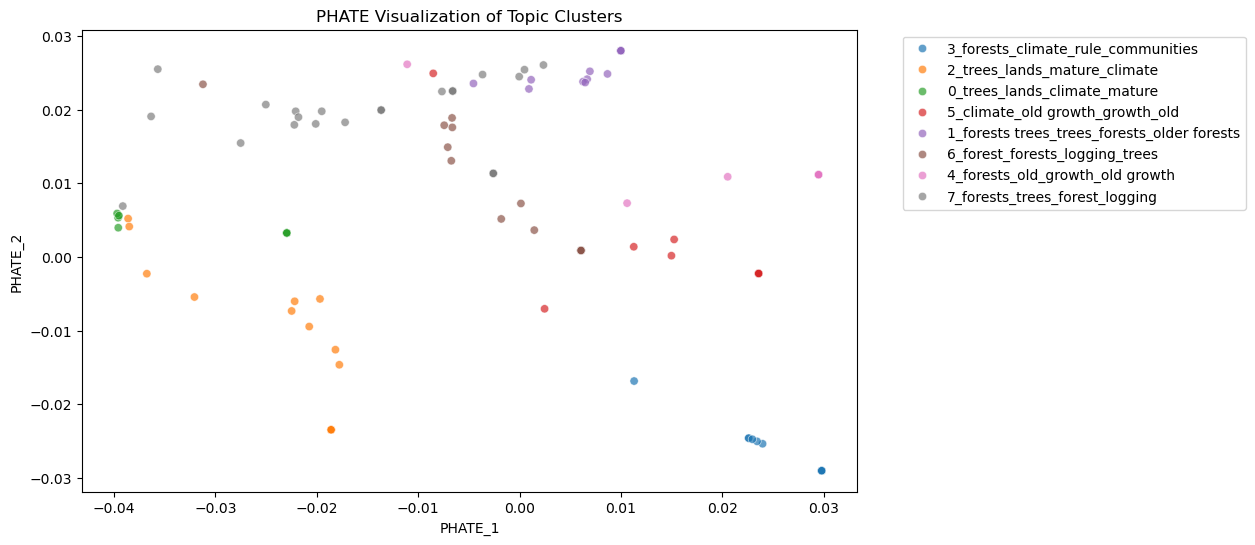

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="PHATE_1", y="PHATE_2", hue="Topic", palette="tab10", alpha=0.7)
plt.title("PHATE Visualization of Topic Clusters")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("phate_visualization.png", dpi=300, bbox_inches="tight")
plt.show()